In [ ]:
import torch
import scanpy as sc
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
from cell2location.utils.filtering import filter_genes

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 

c:\Users\DELL\.conda\envs\cell2loc_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
results_folder = r'01-cell2location'
ref_run_name = f'{results_folder}/Single Cell data'
adata_file = f"{ref_run_name}/sc_trained.h5ad"
adata_ref = sc.read_h5ad(adata_file)

In [ ]:
df = pd.read_csv(r"Normal liver count ensemble.csv", index_col=0)

In [ ]:
df_T = df.T
adata = sc.AnnData(df_T)
adata.var_names = df.index         
adata.obs_names = df.columns  

In [6]:
adata_vis = adata

In [7]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B Cell,Bile_Duct,CD4 T Cell,CD8 T Cell,Dendritic Cell
GeneID-2,,,,,
ENSG00000121410,0.117868,0.028976,0.046961,0.060563,0.016201
ENSG00000148584,0.003872,0.313491,0.001985,0.000445,0.000754
ENSG00000175899,0.005914,0.065284,0.005560,0.006674,0.066956
ENSG00000245105,0.008516,0.000938,0.047738,0.073539,0.001004
ENSG00000128274,0.005289,0.008575,0.000687,0.000120,0.000714


In [ ]:
 adata_vis.obs['sample'] = 'Normal Liver'

In [12]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [13]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 6581  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11443 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Normal Liver │          0          │
└─────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\DELL\.conda\envs\cell2loc_env\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\DELL\.conda\envs\cell2loc_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\DELL\.conda\envs\cell2loc_env\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 20000/20000: 100%|██████████| 20000/20000 [3:36:12<00:00,  1.40it/s, v_num=1, elbo_train=3.18e+7]  

`Trainer.fit` stopped: `max_epochs=20000` reached.


Epoch 20000/20000: 100%|██████████| 20000/20000 [3:36:12<00:00,  1.54it/s, v_num=1, elbo_train=3.18e+7]


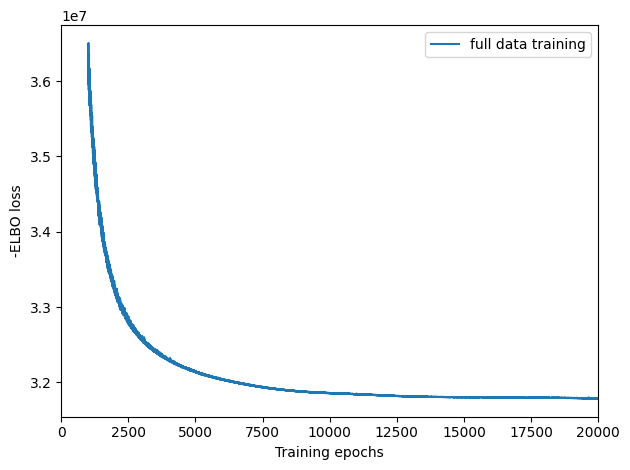

In [14]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          accelerator = 'gpu'
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [16]:
run_name = r'E:\01-TLS\04-SingleCell\11-Bile Duct dataset\Normal-ST'

In [17]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [01:55<00:00,  8.68it/s]


'E:\\01-TLS\\04-SingleCell\\11-Bile Duct dataset\\Normal-ST/sp.h5ad'

In [18]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

adata_vis.obs

,_indices,sample,_scvi_batch,_scvi_labels,B Cell,Bile_Duct,CD4 T Cell,CD8 T Cell,Dendritic Cell,Endothelial,Epithelial,Fibroblast,Macrophage,Neutrophil,Plasma Cell
GCACTCCCACAGTCCC-1_1,0,Normal Liver,0,0,0.076949,2.076148,0.281811,0.356365,0.065281,0.231415,25.756685,0.131399,0.222472,0.069952,0.057977
CAGGATCCGCCCGACC-1_1,1,Normal Liver,0,0,0.142210,2.495542,0.215777,0.240935,0.077185,0.036793,27.389366,0.171899,0.134795,0.228752,0.016269
CAAATGCGGAGTGTTC-1_1,2,Normal Liver,0,0,0.183448,1.195167,0.109633,0.179173,0.163291,0.048445,11.470746,0.288250,0.964311,0.064425,0.059262
GTATCTCCCTAACTGT-1_1,3,Normal Liver,0,0,0.048318,2.223457,0.265927,0.512648,0.046719,0.036990,20.541641,0.092226,0.067876,0.136088,0.016481
ACGTCCTAAACGAGAT-1_1,4,Normal Liver,0,0,0.121984,2.566873,0.181043,0.235099,0.183992,0.043298,27.768272,0.239042,0.361014,0.110918,0.029666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAACGTTTGTATCCAC-1_5,6576,Normal Liver,0,0,1.713954,3.090757,0.187696,0.181639,0.448149,0.264338,50.346954,0.298216,0.703053,0.319924,0.021087
ATTGAATTCCCTGTAG-1_5,6577,Normal Liver,0,0,1.823260,4.218157,0.389716,0.399910,0.434230,0.425004,68.082611,0.267476,0.832163,0.437992,0.043428
TACCTCACCAATTGTA-1_5,6578,Normal Liver,0,0,1.782364,5.834009,0.280470,0.328430,0.422283,0.554130,68.019806,0.428842,0.520231,0.487113,0.014358
AGTCGAATTAGCGTAA-1_5,6579,Normal Liver,0,0,1.838833,3.580056,0.209169,0.230426,0.289857,0.244694,53.180435,0.253059,1.337207,0.436875,0.019023


In [19]:
run_name

'E:\\01-TLS\\04-SingleCell\\11-Bile Duct dataset\\Normal-ST'

In [20]:
adata_vis.obs.to_csv(f"{run_name}/Normal Liver St result.csv")

In [21]:
adata_file = f"{run_name}/Normal_liver_deconvolution.h5ad"
adata_vis.write(adata_file)
adata_file

'E:\\01-TLS\\04-SingleCell\\11-Bile Duct dataset\\Normal-ST/Normal_liver_deconvolution.h5ad'